In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [232]:
# Get synthetic data
data = pd.read_csv('/content/synthetic_immigration_data.csv')

In [233]:
# Clean dates
date_cols = ["Open Date", "Pending Date", "Close Date"]

for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [234]:
# Create year attributes
data['Open Year'] = data['Open Date'].dt.year
data['Pending Year'] = data['Pending Date'].dt.year
data['Closed Year'] = data['Close Date'].dt.year

In [235]:
# Create year-month attributes
data['Open Year-Month'] = data['Open Date'].dt.to_period('M').astype(str)
data['Close Year-Month'] = data['Close Date'].dt.to_period('M').astype(str)
data['Pending Year-Month'] = data['Pending Date'].dt.to_period('M').astype(str)

In [236]:
# Clean dates
data['Open Year-Month'] = pd.to_datetime(data['Open Year-Month'])
data['Close Year-Month'] = pd.to_datetime(data['Close Year-Month'])
data['Pending Year-Month'] = pd.to_datetime(data['Pending Year-Month'])

In [237]:
# Explore the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   CaseID              3000 non-null   object        
 1   Attorney            3000 non-null   object        
 2   Paralegal           3000 non-null   object        
 3   Legal Assistant     3000 non-null   object        
 4   Status              3000 non-null   object        
 5   Open Date           3000 non-null   datetime64[ns]
 6   Pending Date        2100 non-null   datetime64[ns]
 7   Close Date          1260 non-null   datetime64[ns]
 8   Jurisdiction        3000 non-null   object        
 9   Case Type           3000 non-null   object        
 10  Open Year           3000 non-null   int32         
 11  Pending Year        2100 non-null   float64       
 12  Closed Year         1260 non-null   float64       
 13  Open Year-Month     3000 non-null   datetime64[n

In [238]:
# Count Tables Builder Function

def build_all_count_tables(data: pd.DataFrame, *, fill_value: int = 0) -> dict[str, pd.DataFrame]:
    """
    Build all dashboard count tables using systematic loops.

    Requires these columns (at minimum):
    - Status, Jurisdiction
    - Paralegal, Attorney, Legal Assistant
    - Open Year, Pending Year, Closed Year   (if you still use year tables)
    - Open Year-Month, Pending Year-Month, Close Year-Month
    """

    def _key(s: str) -> str:
        # Consistent key formatting: lowercase, remove spaces/hyphens
        return s.lower().replace(" ", "").replace("-", "")

    def _table(row: str, col: str, *, sort_index: bool = False) -> pd.DataFrame:
        t = data.groupby([row, col]).size().unstack(fill_value=fill_value)
        t.index.name = row
        t.columns.name = col
        if sort_index:
            # Useful for Year-Month charts
            t = t.sort_index()
        return t

    tables: dict[str, pd.DataFrame] = {}

    # ------------------------------------------------------------
    # Base dimensions
    # ------------------------------------------------------------
    staff = ["Paralegal", "Attorney", "Legal Assistant"]

    # Keep year tables if those columns still exist in your dataset
    years = ["Open Year", "Pending Year", "Closed Year"]

    # New Year-Month attributes (datetime64[ns] recommended)
    year_months = ["Open Year-Month", "Pending Year-Month", "Close Year-Month"]

    # ------------------------------------------------------------
    # Jurisdiction / Status
    # ------------------------------------------------------------
    tables["count_jurisdiction_status"] = _table("Jurisdiction", "Status")

    for s in staff:
        s_key = _key(s)
        tables[f"count_{s_key}_status"] = _table(s, "Status")
        tables[f"count_{s_key}_jurisdiction"] = _table(s, "Jurisdiction")

    # ------------------------------------------------------------
    # Year-based (only if columns exist)
    # ------------------------------------------------------------
    for y in years:
        if y not in data.columns:
            continue

        y_key = _key(y)
        tables[f"count_{y_key}_status"] = _table(y, "Status", sort_index=True)
        tables[f"count_{y_key}_jurisdiction"] = _table(y, "Jurisdiction", sort_index=True)

        for s in staff:
            s_key = _key(s)
            tables[f"count_{y_key}_{s_key}"] = _table(y, s, sort_index=True)

    # ------------------------------------------------------------
    # Year-Month-based (replaces Month-based)
    # ------------------------------------------------------------
    for ym in year_months:
        if ym not in data.columns:
            continue

        ym_key = _key(ym)

        # Sort index so plots come out chronologically
        tables[f"count_{ym_key}_status"] = _table(ym, "Status", sort_index=True)
        tables[f"count_{ym_key}_jurisdiction"] = _table(ym, "Jurisdiction", sort_index=True)

        for s in staff:
            s_key = _key(s)
            tables[f"count_{ym_key}_{s_key}"] = _table(ym, s, sort_index=True)

    return tables


In [239]:
# Count Tables
counts = build_all_count_tables(data)

# Print keys
for key in counts:
    print(key)

count_jurisdiction_status
count_paralegal_status
count_paralegal_jurisdiction
count_attorney_status
count_attorney_jurisdiction
count_legalassistant_status
count_legalassistant_jurisdiction
count_openyear_status
count_openyear_jurisdiction
count_openyear_paralegal
count_openyear_attorney
count_openyear_legalassistant
count_pendingyear_status
count_pendingyear_jurisdiction
count_pendingyear_paralegal
count_pendingyear_attorney
count_pendingyear_legalassistant
count_closedyear_status
count_closedyear_jurisdiction
count_closedyear_paralegal
count_closedyear_attorney
count_closedyear_legalassistant
count_openyearmonth_status
count_openyearmonth_jurisdiction
count_openyearmonth_paralegal
count_openyearmonth_attorney
count_openyearmonth_legalassistant
count_pendingyearmonth_status
count_pendingyearmonth_jurisdiction
count_pendingyearmonth_paralegal
count_pendingyearmonth_attorney
count_pendingyearmonth_legalassistant
count_closeyearmonth_status
count_closeyearmonth_jurisdiction
count_closeye

In [240]:
# number of keys
print(len(counts))

37


In [241]:
# Pie Chart Generator Function
def plot_pies_from_count_table(count_table: pd.DataFrame) -> None:
    """
    Create one pie chart per column in a grouped count table.
    Each pie shows the distribution across index categories.
    Pie size is proportional to the total number of cases.

    Assumes:
    - index.name   = category being sliced (e.g., Jurisdiction, Paralegal)
    - columns.name = grouping variable (e.g., Status, Jurisdiction)
    """

    # Defensive cleanup
    table = count_table.fillna(0)

    categories = table.index
    groups = table.columns

    totals = table.sum(axis=0)
    max_total = totals.max()

    n_groups = len(groups)

    fig, axes = plt.subplots(1, n_groups, figsize=(6 * n_groups, 6))

    # Normalize axes when there is only one pie
    if n_groups == 1:
        axes = [axes]

    for ax, group in zip(axes, groups):
        counts = table[group]
        total = totals[group]

        # Remove zero slices
        counts = counts[counts > 0]

        radius = total / max_total if max_total > 0 else 1.0

        ax.pie(
            counts,
            labels=counts.index,
            radius=radius,
            autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100 * total)})",
            startangle=90
        )

        # Automated title
        index_name = table.index.name or "Category"
        column_name = table.columns.name or "Group"

        ax.set_title(
            f"{group} by {index_name}\nTotal: {int(total)}"
        )

    plt.tight_layout()
    plt.show()


In [242]:
# Stacked bar chart function

def plot_stacked_case_counts(count_table: pd.DataFrame) -> None:
    """
    Plot a stacked bar chart from a grouped count table.

    Assumes:
    - index.name   = x-axis category (e.g., Paralegal, Attorney)
    - columns.name = stacked category (e.g., Status, Jurisdiction)
    """

    # Ensure clean numeric table
    table = count_table.fillna(0).astype(int)

    # Infer labels from DataFrame metadata
    x_label = table.index.name or "Category"
    legend_title = table.columns.name or "Group"
    title = f"Case Count by {x_label} and {legend_title}"

    ax = table.plot(
        kind="bar",
        stacked=True,
        figsize=(6, 4),
        colormap="tab20"
    )

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Number of Cases")
    ax.tick_params(axis="x", rotation=45)
    plt.setp(ax.get_xticklabels(), ha="right")

    ax.legend(
        title=legend_title,
        bbox_to_anchor=(1.02, 1),
        loc="upper left"
    )

    plt.tight_layout()
    plt.show()

In [243]:
# Line graph generator function

def plot_timeseries_lines(
    count_table: pd.DataFrame,
    *,
    figsize: tuple[int, int] = (6, 4)
) -> None:
    """
    Plot a multi-line time series from a time-indexed count table.

    Assumptions
    -----------
    - Index   = time dimension (Year or Year-Month)
    - Columns = categorical dimension
    - Values  = counts
    """

    # ------------------------------------------------------------------
    # Infer dimension names
    # ------------------------------------------------------------------
    time_dim = count_table.index.name or "Time"
    category_dim = count_table.columns.name or "Category"

    # ------------------------------------------------------------------
    # Reshape to long format
    # ------------------------------------------------------------------
    df_long = (
        count_table
        .reset_index()
        .melt(
            id_vars=time_dim,
            var_name=category_dim,
            value_name="Count"
        )
    )

    # Ensure chronological order
    df_long[time_dim] = pd.to_datetime(df_long[time_dim])

    # ------------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------------
    plt.figure(figsize=figsize)

    sns.lineplot(
        data=df_long,
        x=time_dim,
        y="Count",
        hue=category_dim
    )

    # ------------------------------------------------------------------
    # Auto-generated labels and title
    # ------------------------------------------------------------------
    plt.xlabel(time_dim)
    plt.ylabel("Case Count")
    plt.title(f"Case Counts by {category_dim} Over {time_dim}")

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


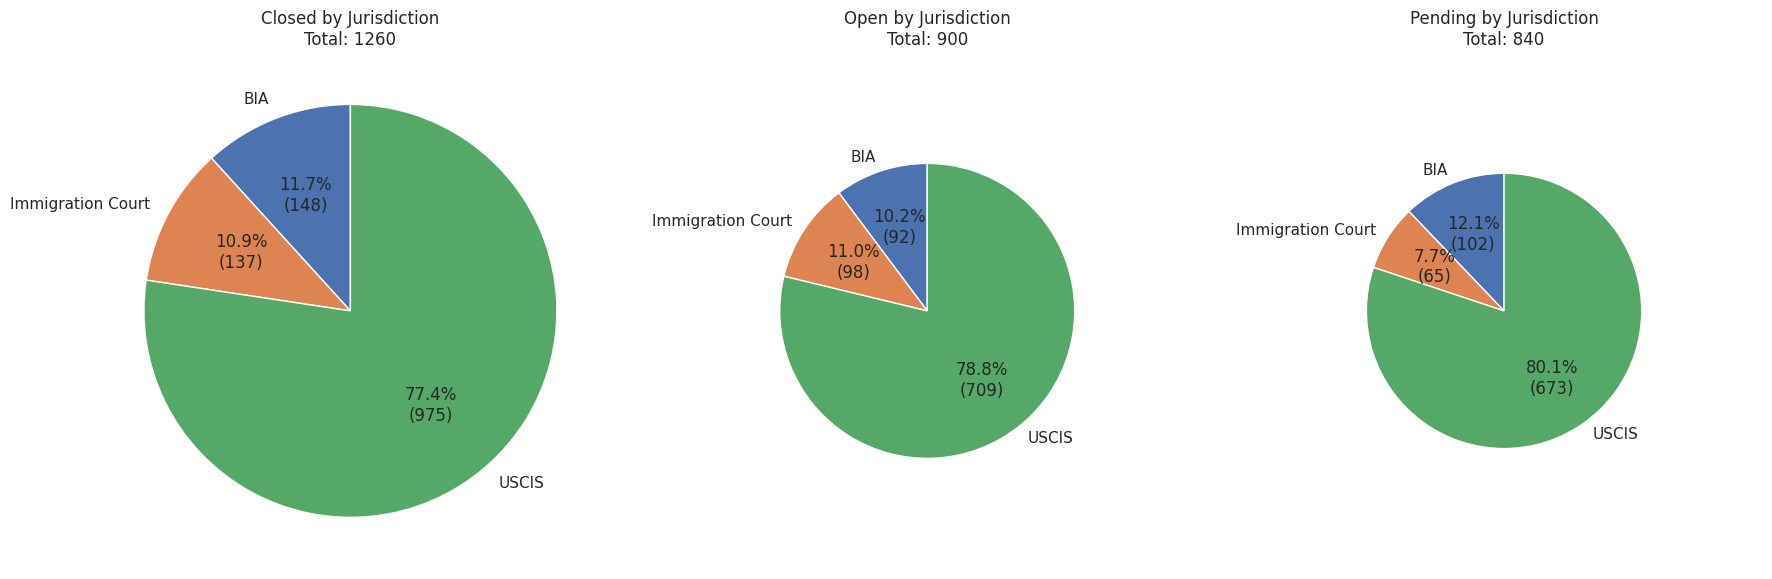

In [244]:
plot_pies_from_count_table(counts['count_jurisdiction_status'])

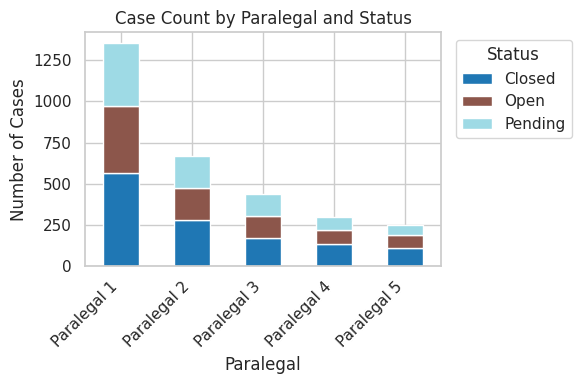

In [245]:
plot_stacked_case_counts(counts['count_paralegal_status'])

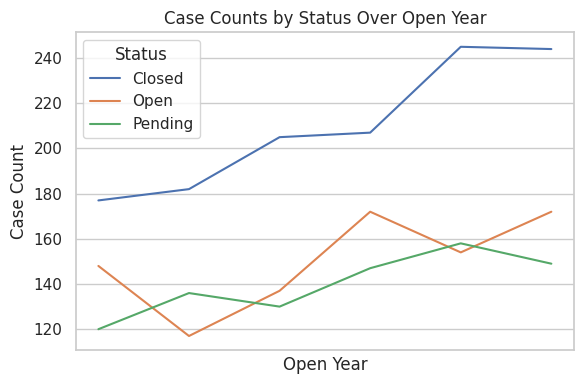

In [246]:
plot_timeseries_lines(counts['count_openyear_status'])

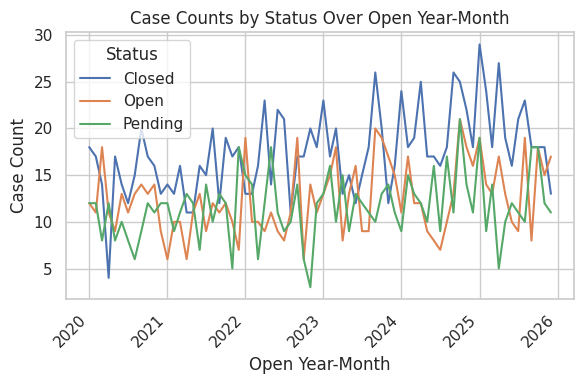

In [247]:
plot_timeseries_lines(counts['count_openyearmonth_status'])

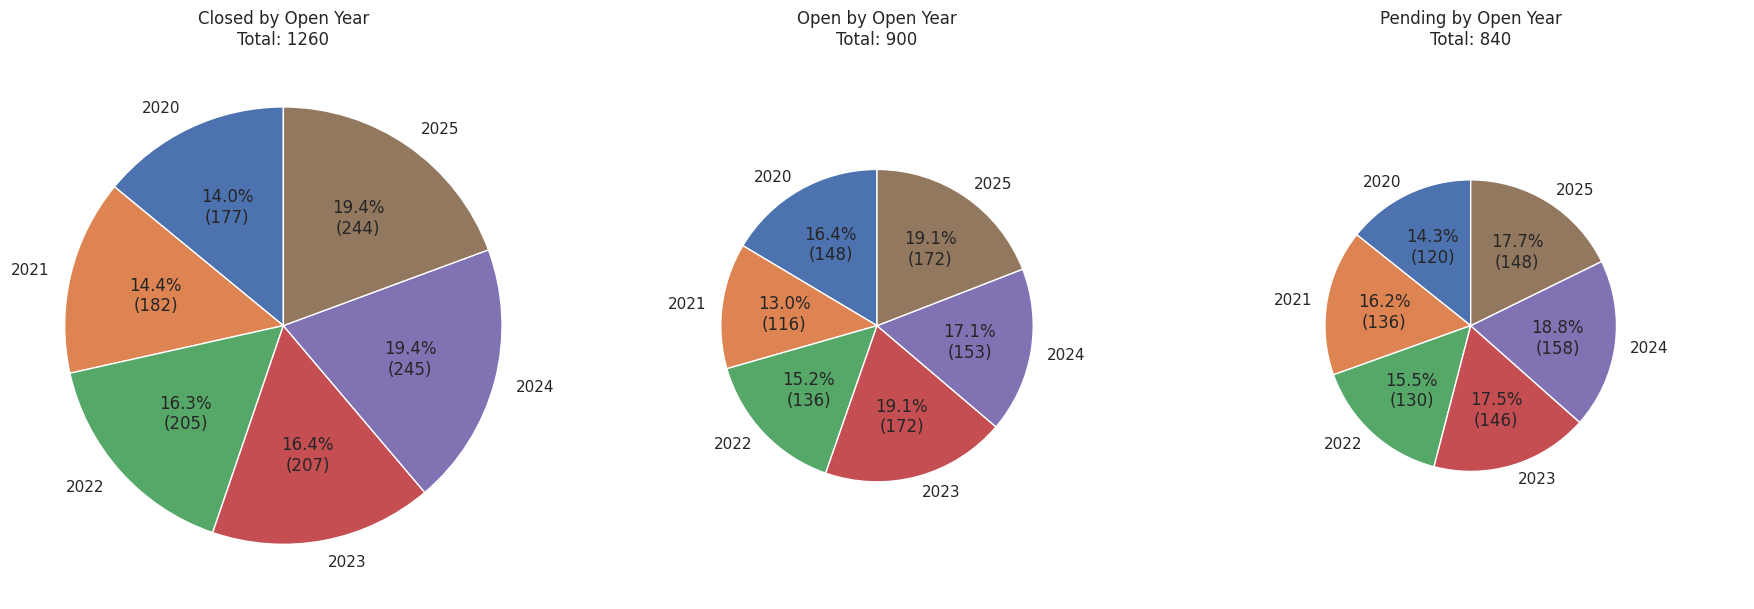

In [248]:
plot_pies_from_count_table(counts['count_openyear_status'])


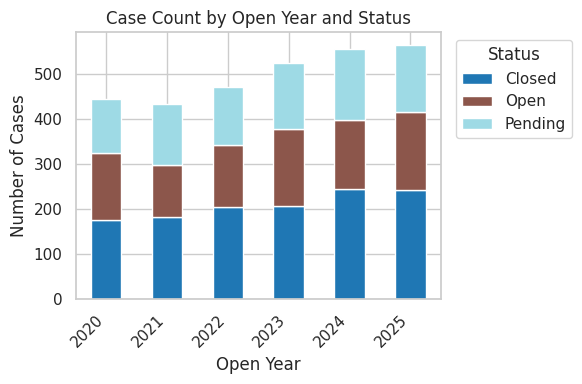

In [249]:
plot_stacked_case_counts(counts['count_openyear_status'])

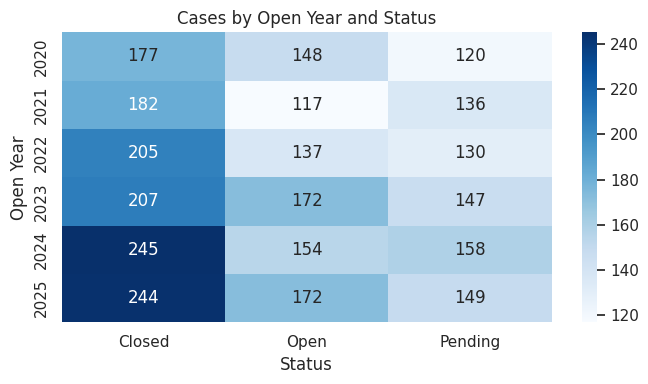

In [250]:
# Heat Map
table = data.groupby(['Open Year', 'Status']).size().unstack(fill_value=0)

plt.figure(figsize=(7, 4))
sns.heatmap(table, cmap="Blues", annot=True, fmt="d")

plt.title("Cases by Open Year and Status")
plt.xlabel("Status")
plt.ylabel("Open Year")
plt.tight_layout()
plt.show()